In [2]:
!rm -rf models train_split logs train

In [3]:
!pip install -q split-folders pytorch_lightning timm

In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

#Работа с текстом
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
import re
import tqdm
import json


from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from nltk.stem.snowball import RussianStemmer

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.svm import LinearSVC

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import gc

from pathlib import Path
import glob

import torch
import torch.nn as nn
import torch.nn.functional as F
import splitfolders
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.datasets import DatasetFolder
from torch.utils.data import DataLoader, Dataset
import pytorch_lightning as pl
from torchmetrics import F1Score
import timm 

# automatic logging of results
from pytorch_lightning.loggers import TensorBoardLogger
# saving weights
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
# tracking lr
from pytorch_lightning.callbacks import LearningRateMonitor
# early stopping
from pytorch_lightning.callbacks.early_stopping import EarlyStopping


import random

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

from pytorch_lightning import seed_everything
seed_everything(7777, workers = True)
RND = 77777

# Датасет

In [10]:
test = pd.read_parquet('/kaggle/input/kazan-express-test/test.parquet')
train = pd.read_parquet('/kaggle/input/kazan-express-test/train.parquet')

In [85]:
train = train.reset_index()
test = test.reset_index()

In [11]:
train.columns

Index(['product_id', 'category_id', 'sale', 'shop_id', 'shop_title', 'rating',
       'text_fields', 'category_name'],
      dtype='object')

In [12]:
test.columns

Index(['product_id', 'sale', 'shop_id', 'shop_title', 'rating', 'text_fields'], dtype='object')

In [13]:
train = train[['product_id', 'shop_id', 'text_fields', 'category_name']]
test = test[['product_id', 'shop_id', 'text_fields']]

In [14]:
train.head(5)

,product_id,shop_id,text_fields,category_name
0,325286,9031,"{""title"": ""Зарядный кабель Borofone BX1 Lightn...",Все категории->Электроника->Смартфоны и телефо...
1,888134,18305,"{""title"": ""Трусы Sela"", ""description"": ""Трусы-...",Все категории->Одежда->Женская одежда->Белье и...
3,1267173,16357,"{""title"": ""Гуашь \""ЮНЫЙ ВОЛШЕБНИК\"", 12 цветов...",Все категории->Хобби и творчество->Рисование->...
4,1416943,34666,"{""title"": ""Колба для кальяна Крафт (разные цве...",Все категории->Хобби и творчество->Товары для ...
5,1058275,26389,"{""title"": ""Пижама женская, однотонная с шортам...",Все категории->Одежда->Женская одежда->Домашня...


In [15]:
test.head(5)

,product_id,shop_id,text_fields
1,1997646,22758,"{""title"": ""Светодиодная лента Smart led Strip ..."
2,927375,17729,"{""title"": ""Стекло ПЛЕНКА керамик матовое Honor..."
3,1921513,54327,"{""title"": ""Проводные наушники с микрофоном jac..."
4,1668662,15000,"{""title"": ""Декоративная табличка \""Правила кух..."
5,1467778,39600,"{""title"": ""Подставка под ложку керамическая, п..."


In [16]:
lecn = LabelEncoder()
train['category_name'] = lecn.fit_transform(train['category_name'])

In [17]:
#category_id в общем-то не нужен, category_name справится за обоих и позволит руками проверить результаты
#Оставил только title из текстовых полей
#Взаимосвязи между категориями и id не обнаружено :)

_______

# Взаимодействие с картинками

_______

# Перемещаем чтобы работать

In [18]:
!mkdir /kaggle/working/train #следующая функция не видит файлы в папке, нужна папка глубже;

In [19]:
!cp -r /kaggle/input/kazan-express-test/images/train /kaggle/working/train/train #можно было перезалить файлы, можно использовать команды, возможно можно иначе
#!mv рандомно начинает ломаться, но при этом все 91120 треин файлов перемещает

In [20]:
# train/valid
splitfolders.ratio(
                    "/kaggle/working/train",
                    output="/kaggle/working/train_split",
                    seed=RND,
                    ratio=(.7, .2, .1), #train val test
                    group_prefix=None,
                    move=False, 
);

Copying files: 91120 files [00:16, 5546.90 files/s]


In [21]:
!ls /kaggle/working/train_split/

test  train  val


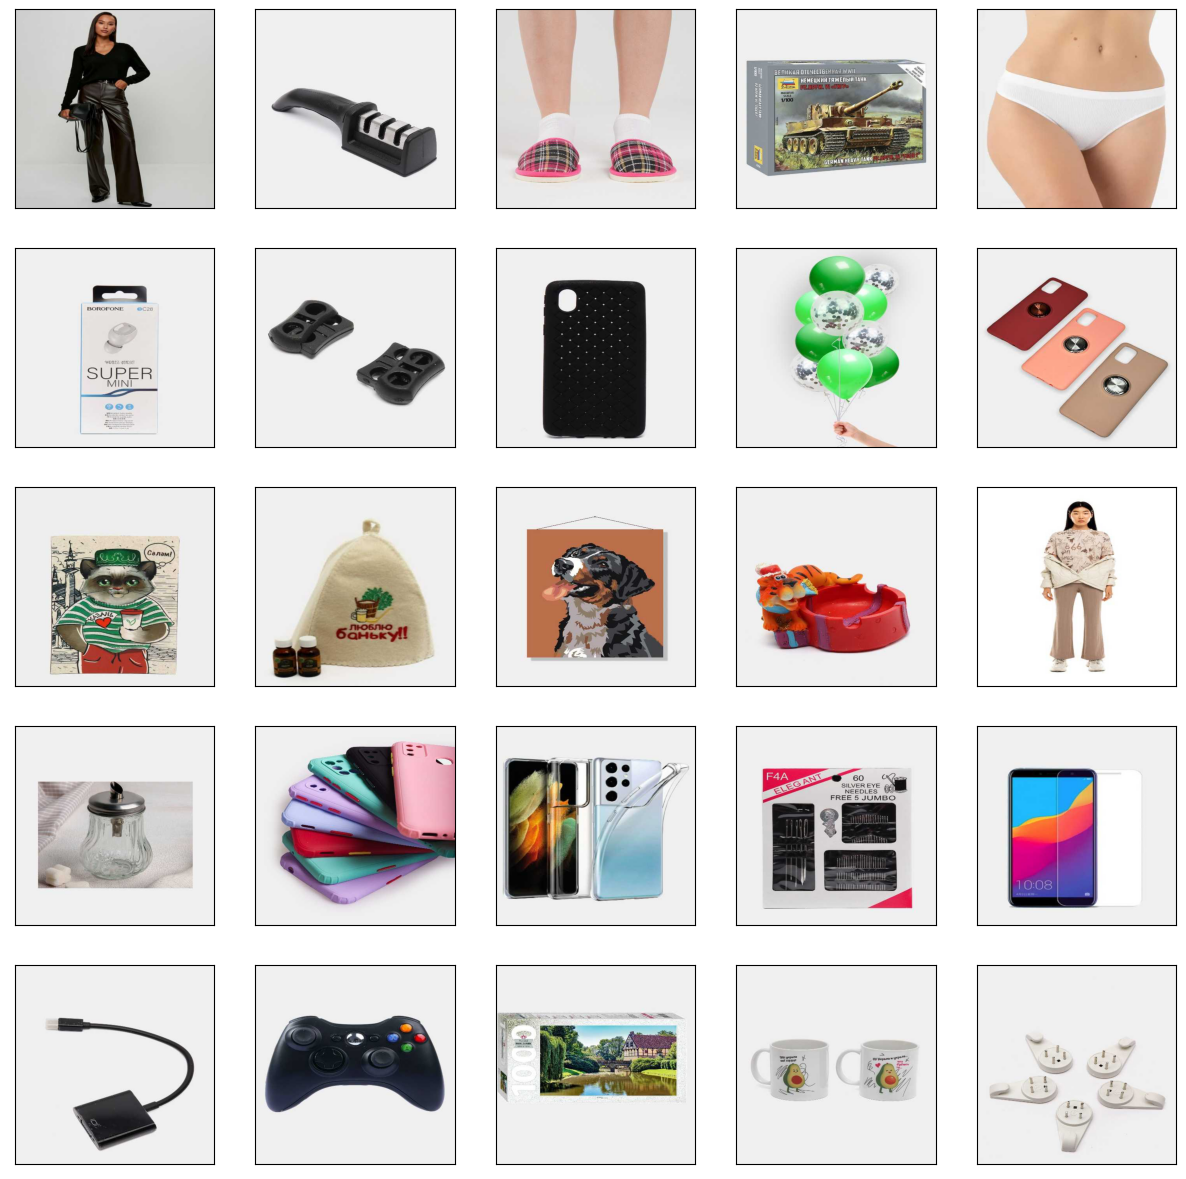

In [35]:
#можно посмотреть на первые 25 картинок в треине

images = [p.resolve() for p in Path("train_split/train").glob("**/*") if p.suffix in {".png", ".jpg", ".jpeg"}]


plt.figure(figsize=(15,15))
i = 0
for image in images[:25]:
    img = Image.open(image)
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img)
    i += 1
plt.show()

# Получение датаеста картинок + переопределение классов

In [22]:
#train/val_set получает из DatasetFolder путь-метка, 
# я не разобрался как переписать find_classes в DF и получал ошибку формата данных после
# и вместо разбиения данных по папкам, пошел этим путем
# попути лучше разобравшись в работе классов и словарей

In [23]:
keyv = {k:v for k, v in train[['product_id','category_name']].to_numpy()}

In [26]:
class ImgDataModule(pl.LightningDataModule):
    def __init__(self,
                 batch_size = 100,
                 train_transform = None,
                 val_transform = None,
                 img_root = '/kaggle/working/train_split',
                 limit_per_class = None
                ):
        super().__init__()
        self.batch_size = batch_size
        self.train_transform = train_transform
        self.val_transform = val_transform
        self.img_root = img_root
        self.temp_targets = []
        #self.val_targets = []
        self.limit = limit_per_class
 
    def one_class_samples_limit(self, reduced):
            classes_0 = {}
            for i in set(self.temp_targets): #присваиваем каждой {уникальной категории : 0}
                classes_0[i] = 0

            counter = 0
            for _ in range(len(reduced)): #ограничитель количества картинок из одной категории
                if classes_0[reduced[counter][1]] < self.limit: #ограничение
                    classes_0[reduced[counter][1]] += 1
                    counter += 1
                else:
                    reduced.remove(reduced[counter]) #удаляет конкретный элемент, если элементов этого класса > limit, тут мы достаем его по индесу


            self.temp_targets = [] #пересоздаем таргеты после изменения семплов
            for i in range(len(reduced)):
                self.temp_targets.append(reduced[i][1])
    
        
    def setup(self, stage=None): 
        
        #----------------------------------------------------------train_set---------------------------------------------------------------------
        
        self.train_set = DatasetFolder(self.img_root / Path('train'), loader=lambda x: Image.open(x), extensions="jpg", transform=self.train_transform)
        
        train_root = self.img_root / Path('train/train')
        
        #----------------------------------------------------------------------------------------------------------------------------------------
        
        for entry in range(len(self.train_set.samples)): #оставляем путь   , меняем таргет, находя значение из {имя_картинки(id):класс}
            self.train_set.samples[entry] = (self.train_set.samples[entry][0], keyv[int( self.train_set.samples[entry][0][len(str(train_root))+1:-4] )])
            self.temp_targets.append( keyv[int( self.train_set.samples[entry][0][len(str(train_root))+1:-4] )]) #список таргеты
        
        if self.limit is not None:
            self.one_class_samples_limit(self.train_set.samples)
        
        
        self.train_set.targets = self.temp_targets #переназначаем основной список таргетов
        self.train_set.classes = sorted( [str(d) for d in list(set(self.temp_targets)) ] )#переназначаем основной список классов
        self.train_set.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.train_set.classes)}
        #-----------------------------------------------------------val_set----------------------------------------------------------------------

        self.val_set = DatasetFolder(self.img_root / Path('val'), loader=lambda x: Image.open(x), extensions="jpg", transform=self.val_transform)
        
        val_root = self.img_root / Path('val/train')        
        
        #----------------------------------------------------------------------------------------------------------------------------------------
        self.temp_targets = []
        
        for entry in range(len(self.val_set.samples)):
            self.val_set.samples[entry] = (self.val_set.samples[entry][0], keyv[int( self.val_set.samples[entry][0][len(str(val_root))+1:-4] )])
            self.temp_targets.append( keyv[int( self.val_set.samples[entry][0][len(str(val_root))+1:-4] )])
            
        if self.limit is not None:
            self.one_class_samples_limit(self.val_set.samples)              
            
        self.val_set.targets = self.temp_targets
        self.val_set.classes = sorted( [ str(d) for d in list(set(self.temp_targets)) ] )
        self.val_set.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.val_set.classes)}
      
    
    def train_dataloader(self):
        return DataLoader(self.train_set, batch_size=self.batch_size, shuffle=True, num_workers=2)
    
    def val_dataloader(self):
        return DataLoader(self.val_set, batch_size=self.batch_size, shuffle=False, num_workers=2)
    
#Может потребоваться дописать if name not in id_list then .remove

In [27]:
class TestImageDataset(Dataset):

    def __init__(self, root_dir, transform=None):

        self.root_dir = root_dir
        self.transform = transform
        self.pictures = []
        
        for filename in sorted(glob.glob(f'{root_dir}/*')):
            im=Image.open(filename).convert('RGB')
            np_im = im
            if self.transform:
                np_im = self.transform(np_im)
            self.pictures.append(np_im)

        self.pictures = torch.stack(self.pictures)
            

    def __len__(self):
        return len(self.pictures)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        sample = self.pictures[idx]

        return sample

In [29]:
images = [p.resolve() for p in Path("train_split/train").glob("**/*") if p.suffix in {".png", ".jpg", ".jpeg"}]
len(images) #кол-во изобр в трейне

63783

In [45]:
dm = ImgDataModule(limit_per_class = 15)

In [46]:
dm.setup() #отрабатывает за 25с при 15 классах, 35с при 30 классах, 0.5с при None

In [34]:
len(dm.train_set.samples)

10373

In [36]:
len(dm.val_set.samples)

8505

In [37]:
dm.train_set.classes[:10]

['0', '1', '100', '101', '102', '103', '104', '105', '106', '107']

In [38]:
#Посчитать сколько каждого класса картинок

classes = {}
for i in set(dm.temp_targets): #присваиваем каждой {уникальной категории : 0}
    classes[i] = 0

counter = 0
for _ in range(len(dm.val_set.samples)): #ограничитель количества картинок из одной категории
    if classes[dm.val_set.samples[counter][1]] < 30: #ограничение
        classes[dm.val_set.samples[counter][1]] += 1
        counter += 1

<AxesSubplot:>

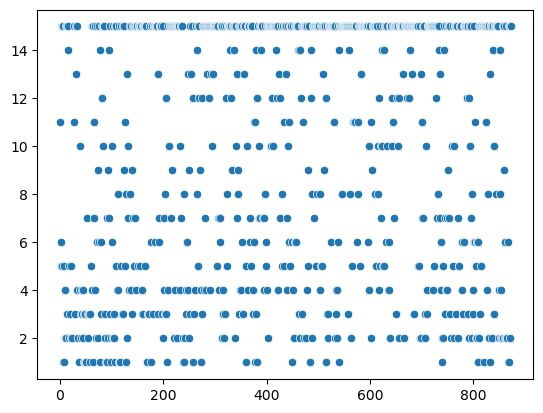

In [40]:
keys = classes.keys()
vals = classes.values()
sns.scatterplot(x=keys, y=vals)

Визуально видно, что у нас очень неоднородное количество представителей классов, <br/>
А так же кажется, что ставить ограничение выше 15 не имеет особого смысла <br/>
А учить на том, что есть - задача мне не по силам <br/>
Лучший скор, который удалось получить на валидации во время обучения - 0.35, <br/>
Но фактичски верно были предсказаны 1.5:13, "точность" порядка 0.11, <br/>
И даже только в 0.25 случаев верный класс был в "топ 5 наиболее вероятных классов" <br/>

Попробовать разобраться как пользоваться этими результатами, а так же пользоваться эмбеддингами, <br/>
которые кстати упоминались в чате - задача на мое ближайшее время, <br/>
но уже выходит за рамки времени отведенного для тестового

In [ ]:
# train.where(train['category_name'] == 831).dropna() #тысяча и...5815 чехлов :)

# AUGM

In [49]:
train_transform = transforms.Compose([
        transforms.RandomPerspective(distortion_scale=0.2, p=0.4, fill=255),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.Resize((232, 232)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
        transforms.RandomPerspective(distortion_scale=0.2, p=0.4, fill=255),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.Resize((232, 232)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])



dataset_transforms = transforms.Compose([
    transforms.Resize((232, 232)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
    ])

In [54]:
len(train['category_name'].value_counts()) #кол-во классов

874

In [7]:
print(timm.list_models('*resnet*',pretrained=True))

['cspresnet50', 'eca_resnet33ts', 'ecaresnet26t', 'ecaresnet50d', 'ecaresnet50d_pruned', 'ecaresnet50t', 'ecaresnet101d', 'ecaresnet101d_pruned', 'ecaresnet269d', 'ecaresnetlight', 'ens_adv_inception_resnet_v2', 'gcresnet33ts', 'gcresnet50t', 'gluon_resnet18_v1b', 'gluon_resnet34_v1b', 'gluon_resnet50_v1b', 'gluon_resnet50_v1c', 'gluon_resnet50_v1d', 'gluon_resnet50_v1s', 'gluon_resnet101_v1b', 'gluon_resnet101_v1c', 'gluon_resnet101_v1d', 'gluon_resnet101_v1s', 'gluon_resnet152_v1b', 'gluon_resnet152_v1c', 'gluon_resnet152_v1d', 'gluon_resnet152_v1s', 'inception_resnet_v2', 'lambda_resnet26rpt_256', 'lambda_resnet26t', 'lambda_resnet50ts', 'legacy_seresnet18', 'legacy_seresnet34', 'legacy_seresnet50', 'legacy_seresnet101', 'legacy_seresnet152', 'nf_resnet50', 'resnet10t', 'resnet14t', 'resnet18', 'resnet18d', 'resnet26', 'resnet26d', 'resnet26t', 'resnet32ts', 'resnet33ts', 'resnet34', 'resnet34d', 'resnet50', 'resnet50_gn', 'resnet50d', 'resnet51q', 'resnet61q', 'resnet101', 'resnet1

# Модель

In [53]:
modelname = 'resnet101d' #'resnet50d' норм и с batchsize=100, для 'efficientnet_b3_pruned' макс bs=~80-85 c resize(300)

In [67]:
class Resnet_Classifier(pl.LightningModule):
    def __init__(self,
                 model = modelname,
                 out_classes = 874,
                 criterion = nn.CrossEntropyLoss(),
                 lr = 3e-4,
                 **kwargs):
        
        super().__init__()
        self.lr = lr
        self.save_hyperparameters(ignore=['criterion']) # save param #ignore из подсказки
        self.model = timm.create_model(model, pretrained=True, num_classes=out_classes)
        
        self.out_classes = out_classes

        self.criterion = criterion
        self.metrics = {'f1score': F1Score(task= 'multiclass', average= 'weighted', num_classes=out_classes).to(DEVICE)} #threshold weighted
        
        for param in self.model.parameters():
            param.requires_grad = False

        for param in self.model.layer3.parameters():
            param.requires_grad = True    

        for param in self.model.layer4.parameters():
            param.requires_grad = True
            
        for param in self.model.global_pool.parameters():
            param.requires_grad = True     
                

        self.model.fc = torch.nn.Sequential(
            torch.nn.Dropout(p=0.3),
            
            torch.nn.Linear(2048, 1024),
            torch.nn.ELU(), #вторая елу подняла лосс и уменьшила val f1
            torch.nn.Linear(1024, 874),
        )      

    def forward(self, x):
        return self.model(x)
        
    def shared_step(self,
                    sample,
                    stage):
        x, y = sample
        preds = self.forward(x)

        loss = self.criterion(preds, y)

        return {
            'loss': loss,
            'f1score': self.metrics['f1score'](preds, y)
        }
        
        
        
    def shared_epoch_end(self,
                         outputs,
                         stage):
        loss = np.mean([x['loss'].item() for x in outputs])
        acc = np.mean([x['f1score'].item() for x in outputs]) 
        metrics = {
            f'{stage}_loss': loss,
            f'{stage}_f1': acc
        }
            
        self.log_dict(metrics, prog_bar=True)
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(),
            lr = self.lr)
        
#     def configure_optimizers(self): #torch.optim.Adam(self.parameters(), lr=1.0e-3)
#         optimizer = torch.optim.SGD(
#             self.parameters(),
#             lr = self.hparams.lr,
#             momentum = 0.9, #weight_decay(1e-4) #l2 coeff
#                             #nesterov = True
#                            #dampening = 0.05
#         )
        
        scheduler_dict = {
            'scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer,
                patience=5
            ),
            'interval': "epoch",
            "monitor": "valid_loss"
        }
        return {'optimizer': optimizer, "lr_scheduler": scheduler_dict}
    
    def training_step(self,
                     batch,
                     batch_idx):
        return self.shared_step(batch, 'train')
    
    def training_epoch_end(self,
                     outputs):
        return self.shared_epoch_end(outputs, 'train')
    
    
    def validation_step(self,
                     batch,
                     batch_idx):
        return self.shared_step(batch, 'valid')
    
    def validation_epoch_end(self,
                     outputs):
        return self.shared_epoch_end(outputs, 'valid')
    
    
    def test_step(self,
                     batch,
                     batch_idx):
        return self.shared_step(batch, 'test')
    
    def test_epoch_end(self,
                     outputs):
        return self.shared_epoch_end(outputs, 'test')

In [68]:
#nn.MultiMarginLoss | out_classes -> nn.LogSoftmax(dim = 1) -> loss
#nn.KLDivLoss       |out_classes -> act -> loss
#nn.CrossEntropyLoss()| out_classes -> loss

In [69]:
BATCH = 100
dm = ImgDataModule(BATCH, train_transform, test_transform, limit_per_class = 15)
lr = 1*10e-2

model = Resnet_Classifier(lr=lr, model=modelname) #nn.MultiMarginLoss

callbacks = [
    ModelCheckpoint(
        dirpath='models',
        filename='{epoch}_{valid_f1:.3f}_{valid_loss:.3f}',
        save_top_k=5,
        monitor='valid_f1',
        mode='max'
    ),
    
    LearningRateMonitor(logging_interval='step'),
    EarlyStopping(monitor='valid_f1',
                  min_delta=2e-3,
                  patience=5, #num epochs
                  verbose=True,
                  mode='max')
]

TENSOR = './logs'
logger = TensorBoardLogger(TENSOR, name=modelname)
CHECKPOINT = None


trainer = pl.Trainer(
    accelerator='gpu',
    devices=1,
    min_epochs=10,
    max_epochs=200,
    logger=logger,
    callbacks=callbacks,
    log_every_n_steps = 5,
    resume_from_checkpoint=CHECKPOINT,
    auto_lr_find = True,
    enable_progress_bar = True
)#deterministic = False

In [70]:
trainer.tune(model, dm) #подбирает оптимальный lr

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

{'lr_find': <pytorch_lightning.tuner.lr_finder._LRFinder at 0x7fc497b46e10>}

In [71]:
trainer.fit(model, dm)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [1]:
#ахритектура
#ep - score
#-----------
#rn26d

#dp0.1, 15, elu, last_unfr
#ep9 0.14
#ep15 0.14

#dp0.1, 30, sigm-elu, full_unfr
#ep 15 0.09

#-----------
#rn50d

#dp0.1, 30, elu, last_unfr 
#ep15 0.35
#ep26 0.36

#-----------
#eff_b3_pr

#dp0.1, 30, elu, last_unfr 
#ep 5 - 0.08
#6 0.1
#16 0.173
#19 0.213
#22 0.29
#26 0.288

#dp0.2, 15, selu, transf_p=0.4, full_unfr
#4 0.01
#19 0.08

#dp0.2, 15, sigm,elu, full_unfr, trasnf_p=0.4 - не обучается, ep10 earlystopping

#dp0.2, 15, elu, transf_p=0.4, last_unf
#9 0.256
#12 0.265

#-----------
#rn101d

#dp0.2, 15, elu-fc-elu-out transf_p=0.4, last_unf
#16 0.274
#25 0.273

#dp0.3, 15, elu-out l34 half_unf
#ep4 0.025
#ep17 0.154
#ep30 0.187
#ep34 0.182

In [72]:
!ls /kaggle/working/models

'epoch=24_valid_f1=0.182_valid_loss=4.706.ckpt'
'epoch=29_valid_f1=0.187_valid_loss=4.705.ckpt'
'epoch=31_valid_f1=0.186_valid_loss=4.723.ckpt'
'epoch=33_valid_f1=0.184_valid_loss=4.724.ckpt'
'epoch=34_valid_f1=0.182_valid_loss=4.709.ckpt'


In [61]:
#!rm -rf models 

In [48]:
# model.cpu()
# del model
# gc.collect()
# torch.cuda.empty_cache()

In [167]:
model.cuda(DEVICE)
model.eval()

correct = 0
total = 0

with torch.no_grad():
        for x, y in iter(dm.val_set):      #на картинках оригинального размера
            x = torch.tensor(x).to(DEVICE) #даже потестить нормально не добрался
            y = torch.tensor(y).to(DEVICE)
            preds = model(x.unsqueeze(0))
            _, predicted = torch.topk(preds, 5)
            
            if y in predicted:
                correct += 1
            total += 1
(correct / total)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


0.25612420034326727

In [141]:
correct

1404

In [142]:
total

12818

______

In [53]:
train.join(test, how='inner', lsuffix='_tr').head(10)

,product_id_tr,shop_id_tr,text_fields_tr,category_name,product_id,shop_id,text_fields
1,888134,18305,"{""title"": ""Трусы Sela"", ""description"": ""Трусы-...",161,1997646,22758,"{""title"": ""Светодиодная лента Smart led Strip ..."
3,1267173,16357,"{""title"": ""Гуашь \""ЮНЫЙ ВОЛШЕБНИК\"", 12 цветов...",649,1921513,54327,"{""title"": ""Проводные наушники с микрофоном jac..."
4,1416943,34666,"{""title"": ""Колба для кальяна Крафт (разные цве...",701,1668662,15000,"{""title"": ""Декоративная табличка \""Правила кух..."
5,1058275,26389,"{""title"": ""Пижама женская, однотонная с шортам...",187,1467778,39600,"{""title"": ""Подставка под ложку керамическая, п..."
6,598728,17424,"{""title"": ""Накладка-чехол на стики для джойсти...",741,1574248,23905,"{""title"": ""Футболка женская с принтом, премиал..."
7,1035042,26110,"{""title"": ""Детские теплые носки"", ""description...",85,342378,12311,"{""title"": ""Топ \""Чебоксарский трикотаж\"""", ""de..."
8,1907369,6815,"{""title"": ""Силиконовый чехол для айфон iPhone ...",831,648979,18389,"{""title"": ""Зарядное устройство/ Адаптер питани..."
9,1110588,28813,"{""title"": ""Футболка женская ТВОЕ, повседневная...",229,248641,9339,"{""title"": ""Трусы женские"", ""description"": ""<p>..."
10,1535362,15520,"{""title"": ""Защитное стекло гибкое (Пленка) Cer...",823,179827,5684,"{""title"": ""Чехол силиконовый для Xiaomi Mi 9"",..."
11,1336137,887,"{""title"": ""Аппликации для детей с наклейками, ...",634,1108406,28813,"{""title"": ""Футболка женская ТВОЕ, на каждый де..."


In [54]:
texts = train['text_fields']

In [55]:
texts[:10]

0     {"title": "Зарядный кабель Borofone BX1 Lightn...
1     {"title": "Трусы Sela", "description": "Трусы-...
3     {"title": "Гуашь \"ЮНЫЙ ВОЛШЕБНИК\", 12 цветов...
4     {"title": "Колба для кальяна Крафт (разные цве...
5     {"title": "Пижама женская, однотонная с шортам...
6     {"title": "Накладка-чехол на стики для джойсти...
7     {"title": "Детские теплые носки", "description...
8     {"title": "Силиконовый чехол для айфон iPhone ...
9     {"title": "Футболка женская ТВОЕ, повседневная...
10    {"title": "Защитное стекло гибкое (Пленка) Cer...
Name: text_fields, dtype: object

In [56]:
def get_titles(texts):
    titles = []
    for entry in tqdm.tqdm(texts.values):
        entry = entry.replace("'", "")
        entry = json.loads(entry)
        titles.append(entry['title'])
    return titles

In [57]:
def preprocess_texts(texts):
    stop_words = set(stopwords.words('russian')) #не несущие смысла слова
    regex = re.compile('[^а-яА-Я]') #регулярка чтобы оставить слова
    preprocess_texts = []
    for i in tqdm.tqdm(range(len(texts))):
        text = texts[i].lower() #нижний регистр
        text = regex.sub(' ', text) #удалим все символы кроме a-z
        word_tokens = word_tokenize(text) #разобьем на слова
        filtered_sentence = [w for w in word_tokens if not w in stop_words] #удаляем не несущие смысл слова
        preprocess_texts.append(' '.join(filtered_sentence))

    return preprocess_texts #возвращаем предобработанный текст

In [58]:
def stemming_texts(texts):
    st = RussianStemmer()
    stem_text = []
    for text in tqdm.tqdm(texts):
        word_tokens = word_tokenize(text)
        stem_text.append(' '.join([st.stem(x) for x in word_tokens.copy()])) 
        
        #у каждого слова отрежем окончания
    return stem_text


In [59]:
data = stemming_texts(preprocess_texts(get_titles(texts)))

100%|██████████| 91120/91120 [00:38<00:00, 2393.97it/s]


In [70]:
data[:10]

['зарядн кабел айфон м',
 'трус',
 'гуаш юн волшебник цвет мл больш баночк высш качеств',
 'колб калья крафт разн цвет',
 'пижам женск однотон шорт',
 'накладк чехол стик джойстик',
 'детск тепл носк',
 'силиконов чехол айфон',
 'футболк женск тво повседневн притален',
 'защитн стекл гибк пленк сяом редм нот']

In [73]:
# def bow(vectorizer, train):#, test):
#     train_bow = vectorizer.fit_transform(train)
#     #test_bow = vectorizer.transform(test)
#     return train_bow #, test_bow

In [82]:
# BOW для Kfold
def bow(vectorizer, train, test):
    train_bow = vectorizer.fit_transform(train)
    test_bow = vectorizer.transform(test)
    return train_bow, test_bow

In [75]:
vectorizer_tf_idf = TfidfVectorizer(ngram_range=(1, 2))

In [76]:
X_train_tf_idf = bow(vectorizer_tf_idf, data)

In [77]:
X_train_tf_idf.shape

(91120, 120367)

In [78]:
clf_svc = LinearSVC()

In [80]:
clf_svc.fit(X_train_tf_idf, train['category_name'])

LinearSVC()

In [81]:
print('LinearSVC:', accuracy_score(clf_svc.predict(X_train_tf_idf), train['category_name']))

LinearSVC: 0.9673178226514486


In [83]:
def create_folds(data, target, num_splits=3):
    if num_splits > 1:
        data.loc[:,'kfold'] = -1
        X = data.drop([target], axis=1)
        y = data[[target]]
        mskf = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)
        for fold, (trn_, val_) in enumerate(mskf.split(X, y)):
            data.loc[val_,'kfold'] = fold
    else:
        data.loc[:,'kfold'] = 0
    return data

In [86]:
N = 5
df = create_folds(train, 'category_name', N)
X = df.drop(columns=['category_name'])
y = df[['category_name', 'kfold']]

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


In [87]:
val_ds = pd.DataFrame({'true': y['category_name']})
val_ds['pred'] = -1
for kfold in range(5):
    X_train, X_test = X[X.kfold!=kfold].drop('kfold', axis=1), X[X.kfold==kfold].drop('kfold', axis=1)
    y_train, y_test = y[y.kfold!=kfold].drop('kfold', axis=1), y[y.kfold==kfold].drop('kfold', axis=1)
    print(X_train.shape)
    print(f'--------------------------------{kfold}-fold-------------------------------')
    
    X_train['data'] = stemming_texts(preprocess_texts(get_titles(X_train['text_fields'])))    
    X_test['data'] = stemming_texts(preprocess_texts(get_titles(X_test['text_fields'])))
    X_tr, X_te = bow(vectorizer_tf_idf, X_train['data'], X_test['data'])
    #своя модель
    clf_svc = LinearSVC()
#     #clf = LinearRegression()
    clf_svc.fit(X_tr, y_train['category_name'])

    val_ds.loc[y_test.index, 'pred'] = clf_svc.predict(X_te).astype(int)

(72896, 4)
--------------------------------0-fold-------------------------------


100%|██████████| 18224/18224 [00:07<00:00, 2366.59it/s]


(72896, 4)
--------------------------------1-fold-------------------------------


100%|██████████| 18224/18224 [00:07<00:00, 2363.67it/s]


(72896, 4)
--------------------------------2-fold-------------------------------


100%|██████████| 18224/18224 [00:07<00:00, 2387.33it/s]


(72896, 4)
--------------------------------3-fold-------------------------------


100%|██████████| 18224/18224 [00:07<00:00, 2410.22it/s]


(72896, 4)
--------------------------------4-fold-------------------------------


100%|██████████| 18224/18224 [00:07<00:00, 2392.72it/s]


In [88]:
f1_score(val_ds['true'], val_ds['pred'], average='weighted')

0.8402438943154364